# exploration 4번째 과제</br>
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [266]:
import math
import warnings
import os
import sys
import numpy as np
import pandas as pd
from enum import Enum
from matplotlib import pyplot as plt
from pathlib import Path
from typing import Union

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## 상수선언

In [267]:
class P_ValueThresholdPercent(Enum):
    """
    사회과학과 자연과학간의 p-value 역치
    역치는 백분율이다.
    """
    social_science = 5 # 사회과학 데이터용
    natural_science = 1 # 자연과학 데이터용

TIME_COL = "Close"

# [file name]:[company name]
COM_DICT = {
    "KO.csv" : "kokacola"
}

warnings.filterwarnings('ignore') #경고 무시

DATA_PATH = os.path.join(Path("./").parent.resolve().parent.resolve().parent.resolve(),"data")

## 함수선언

In [268]:
def plot_rolling_statistics(
    timeseries:pd.Series
    , window=12
) -> Union[pd.Series, None]:
    """
    시계열 데이터를 log정규화 후
    데이터에 대한 이동평균과 이동표준편차를 계산, 그래프 작성
    만약 NaN값이 존재할 경우 데이터를 선형보간한다.

    Parameters
    ----------
    timeseries : Series of datetime64
        시게열 데이터
    window : int, default = 12
        시게열 데이터의 반복주기
        기본값은 12로 1년데이터를 기준으로 한다.

    Returns
    ----------
    timeseries : Series
        - 보간이 된 시계열 데이터

    """
    timeseries = np.log(timeseries)

    # 결측치 보간
    if timeseries.isna().any():
        timeseries = timeseries.interpolate(method='time')
    
    rolling = timeseries.rolling(window=window)  # 구간통계

    # 시각화
    orig = plt.plot(timeseries, color='blue',label='Original') # 원본    
    mean = plt.plot(rolling.mean(), color='red', label='Rolling Mean') # 이동평균
    std = plt.plot(rolling.std(), color='black', label='Rolling Std') # 이동표준편차
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    return timeseries

시계열 데이터를 `NaN`값은 선형보간에 의해 값을 보간한다.</br>
그 후, 원본, 이동평균, 이동표준편차를 확인하기 위한 그래프를 그린다.

In [269]:
def plot_seasonal_decompose(timeseries:pd.Series) -> None:
    """
    시계열 데이터를 
     - 추세
     - 계절성
     - 원본 - 추세 - 계절성
    로 분해해 그래프로 표시
    그 중 residual요소만 리턴

    Parameters
    ----------
    timeseries : Series of datetime64
        시게열 데이터

    Returns
    ----------
    residual : Series
        
    """

    decomposition = seasonal_decompose(timeseries, model='multiplicative', period = 30) 

    trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
    seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
    residual = decomposition.resid # 원본 - 추세 - 계절성


    plt.figure(figsize=(10,6))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

    return residual

시계열 분해 (Time Series Decomposition) 후 각각 트렌트, 계절성, 그 이외의 성질을 그래프로 나타냄

In [270]:
def augmented_dickey_fuller_test(
    timeseries:pd.Series
    , p_value_threshold:P_ValueThresholdPercent=P_ValueThresholdPercent.social_science
    ) -> bool:
    """
    아래의 상황에서 경고를 출력
     - p-value가 역치이하

    Parameters
    ----------
    timeseries : Series of datetime64
        시게열 데이터
    p_value_threshold : P_ValueThresholdPercent, default = P_ValueThresholdPercent.social_science
        p-value의 역치값을 설정
        기본은 사회과학 데이터 기준이다.
        설정관련 사항은 아래와 같다.
        - 사회과학 분야의 데이터 경우 : social_science(5%)
        - 자연과학 분야의 데이터 경우 : natural_science(1%)

    Returns
    ----------
    is_stationary : bool
        안정적 시계열 여부
    """
    is_stationary = True

    # 시계열 데이터 검증값 계산
    adfuller_value = adfuller(timeseries, autolag='AIC')

    critical_value = adfuller_value[4]
    adfuller_value = adfuller_value[:4]
    
    adfuller_value = {
        col:v 
        for v, col in 
        zip(
            adfuller_value, ['Test Statistic','p-value','#Lags Used','Number of Observations Used']
        )
    }

    adfuller_value.update({
        f"Critical Value ({k})":v 
        for k, v in 
        critical_value.items()
    })

    # 다음의 상황을 시계열이 연속적이지 않다고 가정한다.
    # - p-value가 역치를 넘을 경우
    if adfuller_value["p-value"] > p_value_threshold.value / 100:
        print("stationary한 시계열 데이터가 아닙니다.")
        is_stationary = False
        

    for k,v in adfuller_value.items():
        print(f"{k} : {v}")

    return is_stationary

시계열 데이터가 다음의 조건일 경우 경고메세지 출력.
 - p-value가 역치이상

## 실행

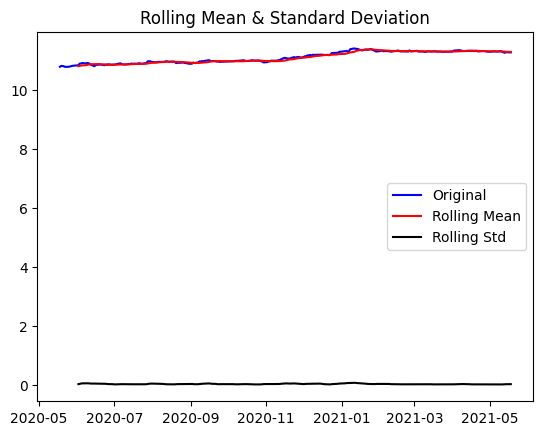

stationary한 시계열 데이터가 아닙니다.
Test Statistic : -1.3835246914203967
p-value : 0.5901486083403977
#Lags Used : 0
Number of Observations Used : 249
Critical Value (1%) : -3.4568881317725864
Critical Value (5%) : -2.8732185133016057
Critical Value (10%) : -2.5729936189738876


In [271]:
dataset_filepath = os.path.join(DATA_PATH, '005930.KS.csv')
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

close = df.pop(TIME_COL)
close = plot_rolling_statistics(close)

augmented_dickey_fuller_test(close)

df = pd.concat([df, close], axis=1)
cols = df.columns.to_list()
cols.remove(TIME_COL)
df = df[cols].interpolate(method="values")

해당 과정을 시행한다.
 - `Nan`값에 대한 선형보간
 - 원본, 이동평균, 이동표준편차를 확인하기 위한 그래프 작성

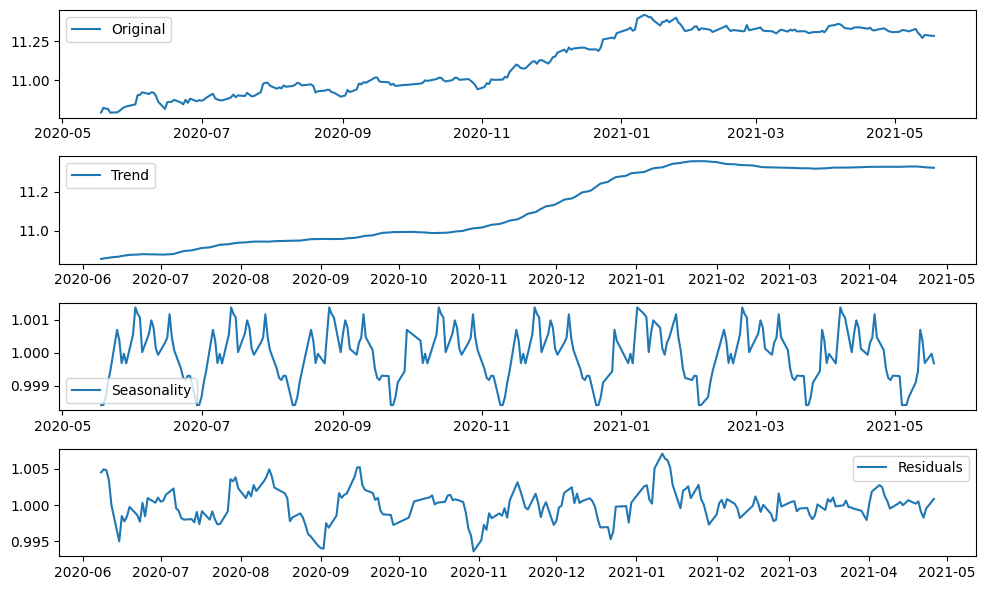

In [272]:
residual = plot_seasonal_decompose(close)
residual.dropna(inplace=True)

다음과 같은 동작을 수행한다.
- 시계열 분해 후, Residual 안정성 확인(분석 및 그래프 작성)
    - 정성적 그래프 분석
    - 정량적 그래프 분석
    - 원본(로그변환한) - 추세 - 계절성
- `Nan`값 필터링

In [273]:
augmented_dickey_fuller_test(residual)

Test Statistic : -6.1875855954225
p-value : 6.234854469399257e-08
#Lags Used : 9
Number of Observations Used : 210
Critical Value (1%) : -3.461878735881654
Critical Value (5%) : -2.875403665910809
Critical Value (10%) : -2.574159410430839


True

시계열 데이터가

 > stationary한 시계열 데이터가 아닙니다.

라는 메세지가 출력될 경우</br>
stationary가 되지 않음.

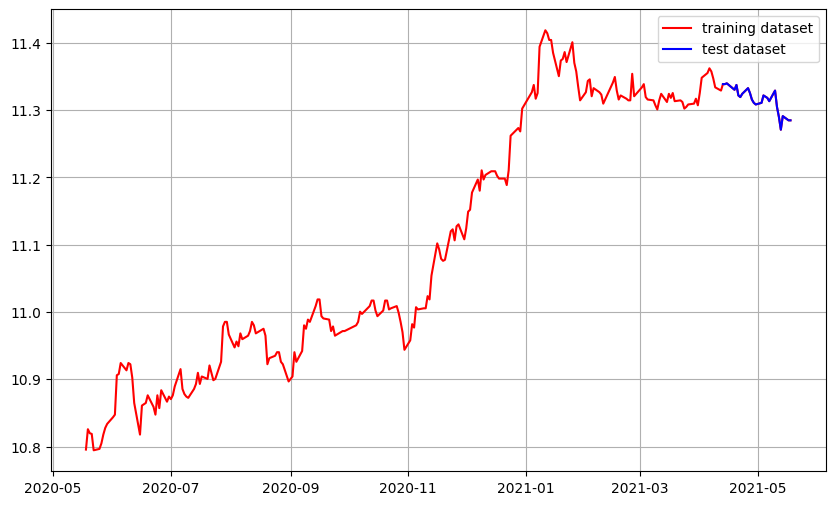

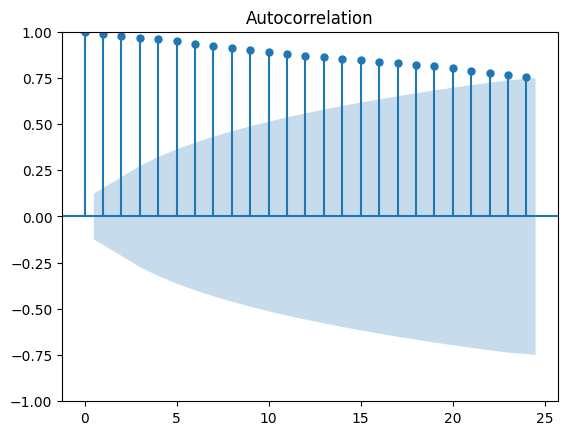

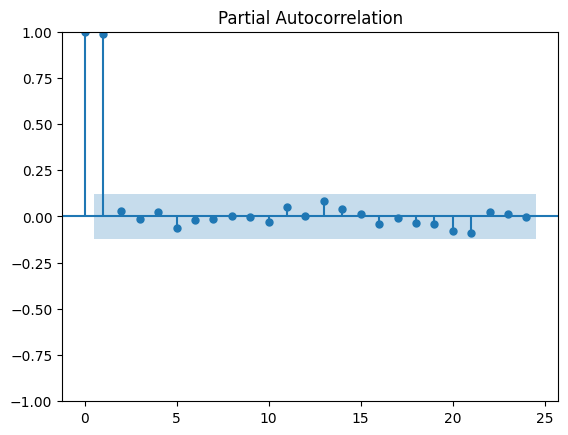

In [274]:
# train, test data 생성
train_data, test_data = close[:int(len(close)*0.9)], close[int(len(close)*0.9):]

# 예측된 주식가격 예측
plt.figure(figsize=(10,6)), 
plt.grid(True)
plt.plot(close, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

plot_acf(close)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(close, method="ywm")  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


train data, test data를 9:1로 생성 후</br>
그래프를 그려 아래의 사실을 가능</br>
 - ACF그래프에서 하강이 완만한 경우 차분화 필요
 - PACF가 0으로 수렴하지 않는 경우 차분화 필요

Test Statistic : -15.536987202555839
p-value : 2.1837375080919526e-28
#Lags Used : 0
Number of Observations Used : 248
Critical Value (1%) : -3.4569962781990573
Critical Value (5%) : -2.8732659015936024
Critical Value (10%) : -2.573018897632674


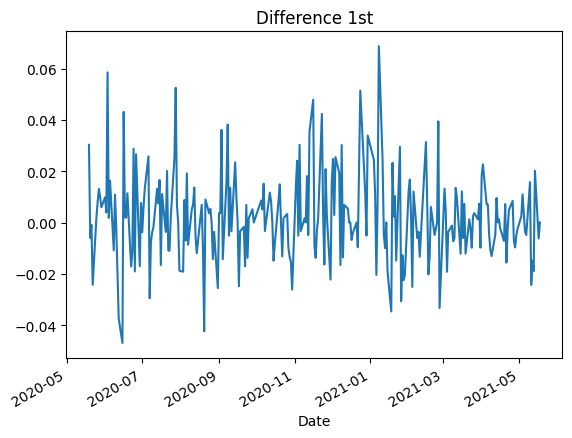

In [275]:

# 차분 구하기
d = 0
diff = None

while True:
    diff = close.diff(periods=1).iloc[1:]
    diff.plot(title=f'Difference {d+1}st')
    if augmented_dickey_fuller_test(diff):
        break
    d += 1

`[차분한 횟수] -1`를 `ARIMA`의 `d`로 설정

C:\Users\Owner\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Owner\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Owner\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Owner\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given wit

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Fri, 30 Sep 2022   AIC                          -1156.722
Time:                        21:20:06   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

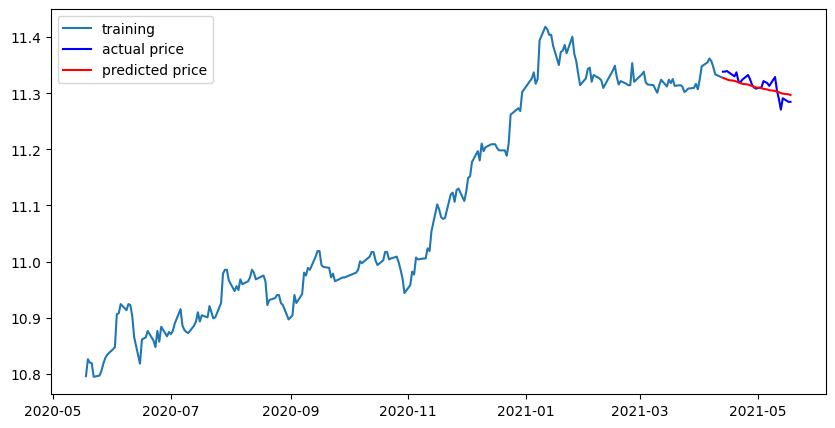

MSE:  1048973.6014239227
MAE:  843.757953150685
RMSE:  1024.1941229200268
MAPE: 1.03%


In [276]:
# p,d,q 순서대로 arima 모델 적용
model = ARIMA(train_data, order=(2, d, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))